In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyCO2SYS as pyco2
import string

df = pd.read_csv("../../compilation/data/in_situ_rates_compiled_allvar_uncertainty.csv")
print(df.columns)

df_cdisk = df[df['Source_abbrev'].isin(['N19', 'D19', 'S22'])].copy()

Index(['Depth', 'Source', 'Source_abbrev', 'Latitude', 'Longitude', 'Sample',
       'Material', 'Rate_sa', 'Rate_error_sa', 'Organics', 'Device',
       'Deployment_d', 'Biogenic', 'Year', 'Comments', 'Mesh', 'Rate_mass',
       'Month', 'Size', 'Fragmentation_pct', 'Rate_error_mass', 'Temp_CDisk4',
       'pH_CDisk4_T25', 'Salinity_CDisk4', 'TA_CDisk4', 'DIC_CDisk4_calc13',
       'Oca_CDisk4_calc13', 'Oar_CDisk4_calc13', 'Omega_CDisk4_calc13',
       'Pressure', 'Temp_woa', 'Temp_SD_woa', 'Sal_woa', 'Sal_SD_woa',
       'Doxy_woa', 'Doxy_SD_woa', 'PO4_woa', 'SiOH4_woa', 'TA_cb', 'DIC_cb',
       'NO3_cb', 'PO4_cb', 'SiOH4_cb', 'pH_insitu_cb', 'k_calcite_calc23',
       'Oca_calc23', 'k_aragonite_calc23', 'Oar_calc23',
       'total_calcium_calc23', 'CO2_calc23', 'HCO3_calc23', 'CO3_calc23',
       'Omega_calc23', 'Oca_metab_calc12', 'Oar_metab_calc12',
       'Omega_metab_calc12', 'u_TA_woa', 'u_DIC_woa', 'u_pH_insitu_woa',
       'u_SiOH4_woa', 'u_PO4_woa', 'u_TA_woa_cb', 'u_DIC_wo

## Uncertainty in CDisk4 data

In [11]:
# add uncertainty
df_cdisk['u_TA_CDisk4'] = 4 # n19
df_cdisk['u_pH_CDisk4'] = 0.001 # n19
df_cdisk['u_PO4_CDisk4'] = 0.03 # n19, their uncertainty but 'my' nutrient data
df_cdisk['u_SiOH4_CDisk4'] = 1.5 # n19, their uncertainty but 'my' nutrient data
df_cdisk['u_Temp_CDisk4'] = df_cdisk["Temp_CDisk4"]*0.02 # based on Table 3, GLODAPv2.2022 data
df_cdisk['u_Sal_CDisk4'] = 0.005 # based on Table 3, GLODAPv2.2022 data


# re-calculate Omega_calc for CDisk so I have the uncertainty
cdisk = pyco2.sys(par1=df_cdisk["TA_CDisk4"], 
                    par2=df_cdisk["pH_CDisk4_T25"], 
                    par1_type = 1, par2_type=3, 
                    salinity=df_cdisk["Salinity_CDisk4"], 
                    temperature_out=df_cdisk["Temp_CDisk4"], 
                    pressure_out=df_cdisk["Pressure"],
                    total_silicate=df_cdisk["SiOH4_cb"], 
                    total_phosphate=df_cdisk["PO4_cb"],
                  uncertainty_into=["saturation_calcite_out", "saturation_aragonite_out"],
                  uncertainty_from={
                      "par1": df_cdisk['u_TA_CDisk4'],
                      "par2": df_cdisk['u_pH_CDisk4'],
                      "salinity": df_cdisk['u_Sal_CDisk4'] ,                   
                      "temperature": df_cdisk['u_Temp_CDisk4'],
                      "total_silicate": df_cdisk['u_SiOH4_CDisk4'],
                      "total_phosphate": df_cdisk['u_PO4_CDisk4']})


df_cdisk["pH_insitu_CDisk4"] = cdisk['pH_out']

df_cdisk["Oca_CDisk4_calc13_calc"] = cdisk['saturation_calcite_out']
df_cdisk["Oar_CDisk4_calc13_calc"] = cdisk['saturation_aragonite_out']
df_cdisk["u_Oca_CDisk4_calc13_calc"] = cdisk['u_saturation_calcite_out']
df_cdisk["u_Oar_CDisk4_calc13_calc"] = cdisk['u_saturation_aragonite_out']


df_cdisk["Omega_CDisk4_calc13_calc"] = np.where(df_cdisk["Material"].eq("Aragonite"), 
                                             df_cdisk["Oar_CDisk4_calc13_calc"], df_cdisk["Oca_CDisk4_calc13_calc"])
df_cdisk["u_Omega_CDisk4_calc13_calc"] = np.where(df_cdisk["Material"].eq("Aragonite"), 
                                             df_cdisk["u_Oar_CDisk4_calc13_calc"], df_cdisk["u_Oca_CDisk4_calc13_calc"])

## Figure S9

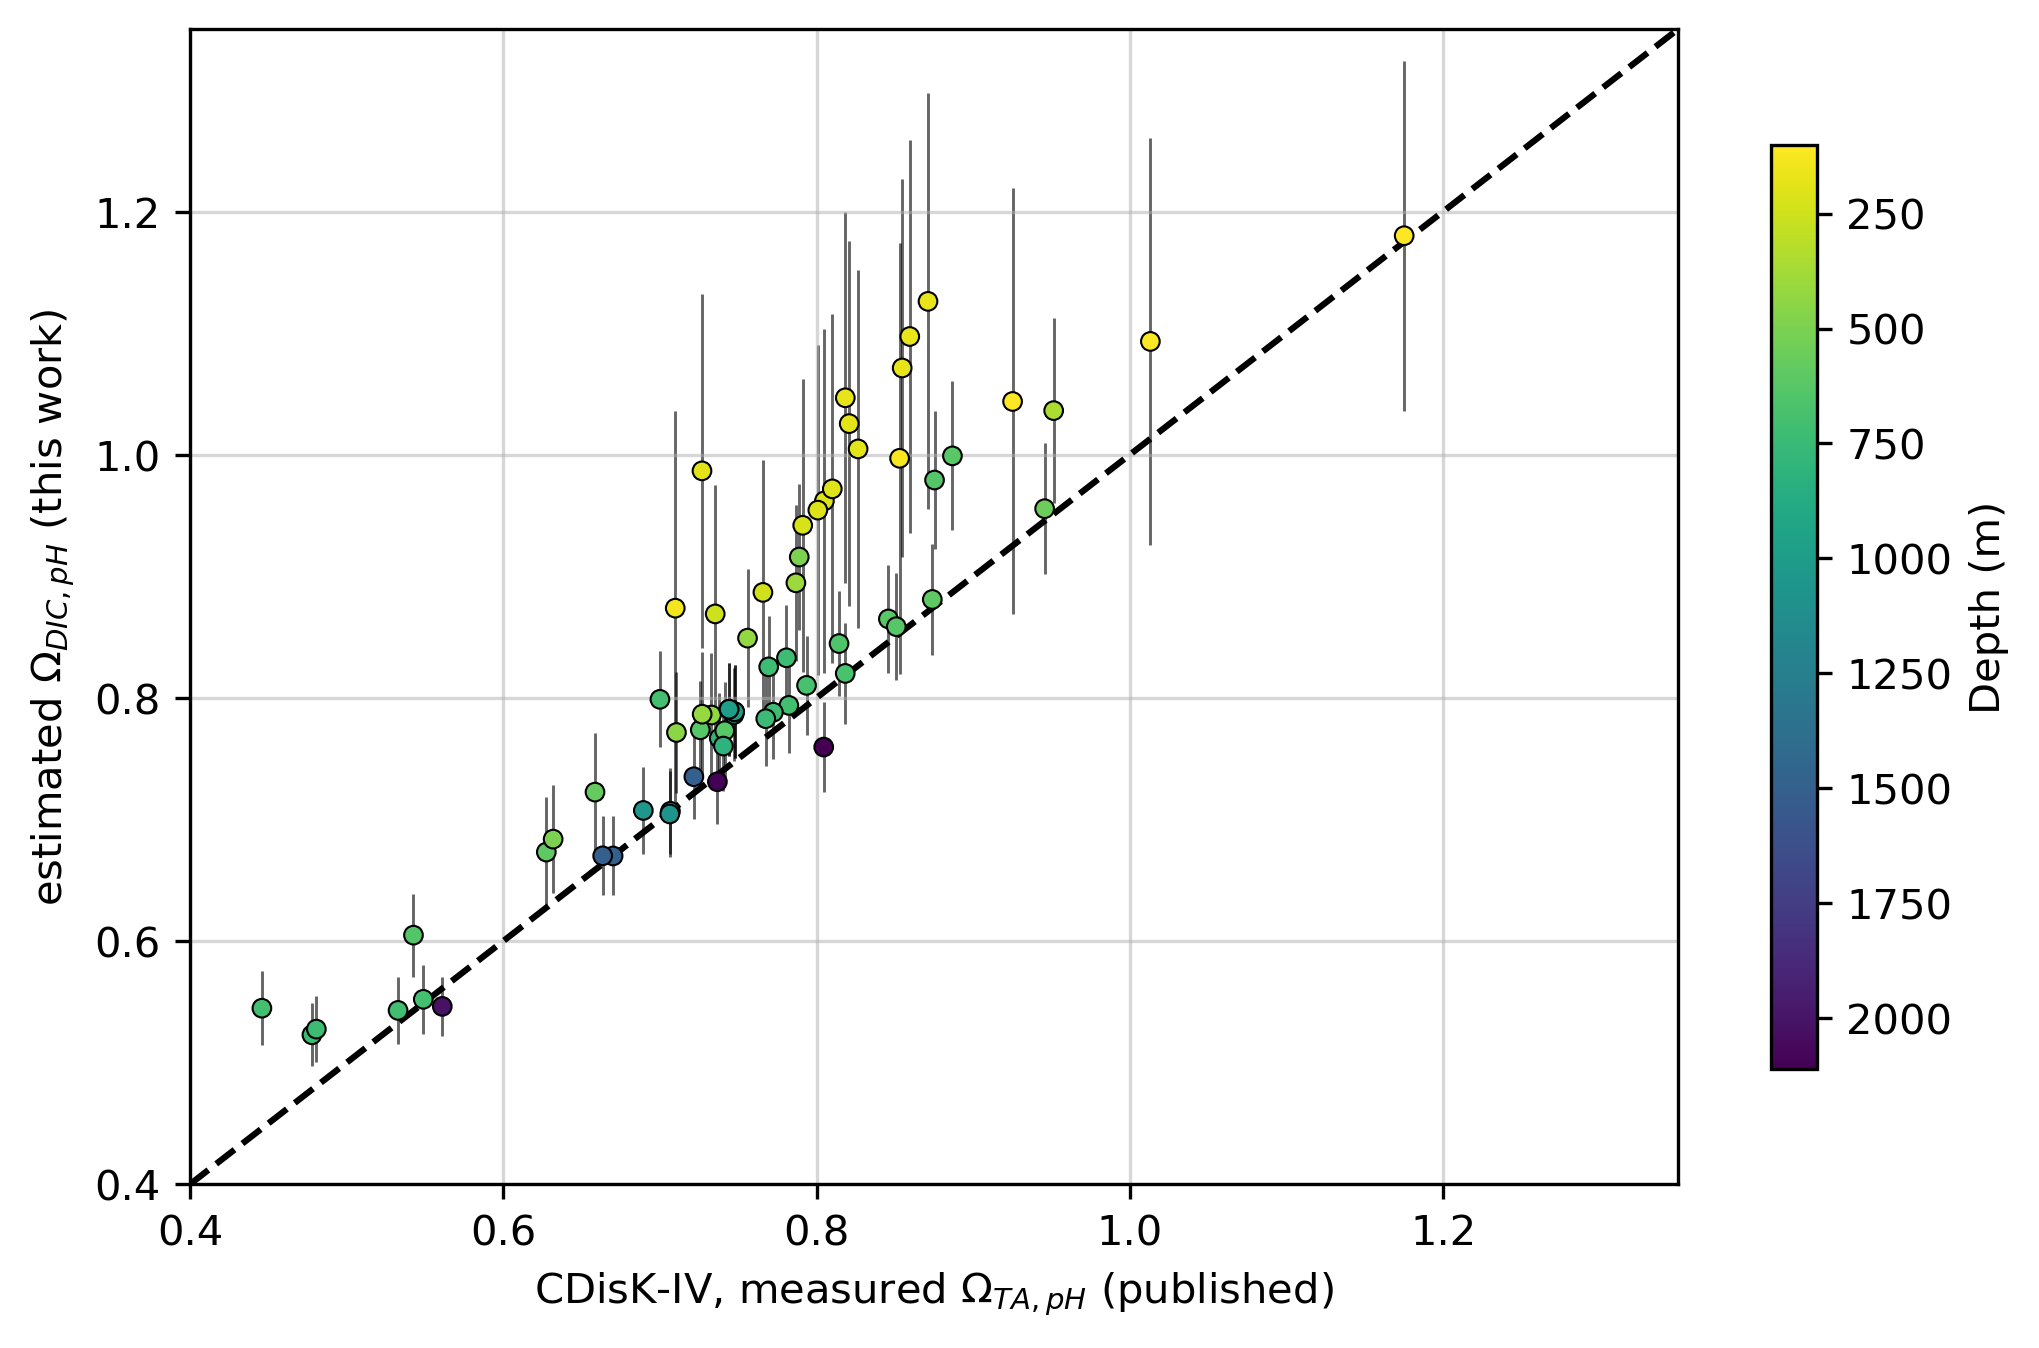

In [12]:
plt.figure(figsize=(8,5), dpi=300)

scatter_kwargs = {"zorder":100}
error_kwargs = {"lw":.7, "zorder":0}

plt.errorbar(df_cdisk['Omega_CDisk4_calc13_calc'], df_cdisk['Omega_calc23'], 
             xerr=df_cdisk['u_Omega_CDisk4_calc13_calc'], yerr=df_cdisk['u_Omega_calc23'], 
             fmt='.', marker=None, color='black', alpha=0.6, **error_kwargs)
cb = plt.scatter(df_cdisk['Omega_CDisk4_calc13_calc'], df_cdisk['Omega_calc23'], c=df_cdisk['Depth'], cmap='viridis_r',
             s=20, edgecolor='black', linewidth=0.5, **scatter_kwargs)

cbar = plt.colorbar(cb, label='Depth (m)', shrink=0.8, pad=0.05) 
cbar.ax.invert_yaxis()
    

plt.axline((1,1), slope=1, color='black', linestyle='--')
plt.xlim(0.4,1.35)
plt.ylim(0.4, 1.35)
plt.grid(alpha=0.5)
plt.xlabel('CDisK-IV, measured $\Omega_{TA,pH}$ (published)')
plt.ylabel('estimated $\Omega_{DIC,pH}$ (this work)')
#plt.title('Comparison of measured $\Omega$ in n19, d19, s22 \n and estimated $\Omega$ from WOA18 and CANYON-B')
plt.show()

## Figure S10

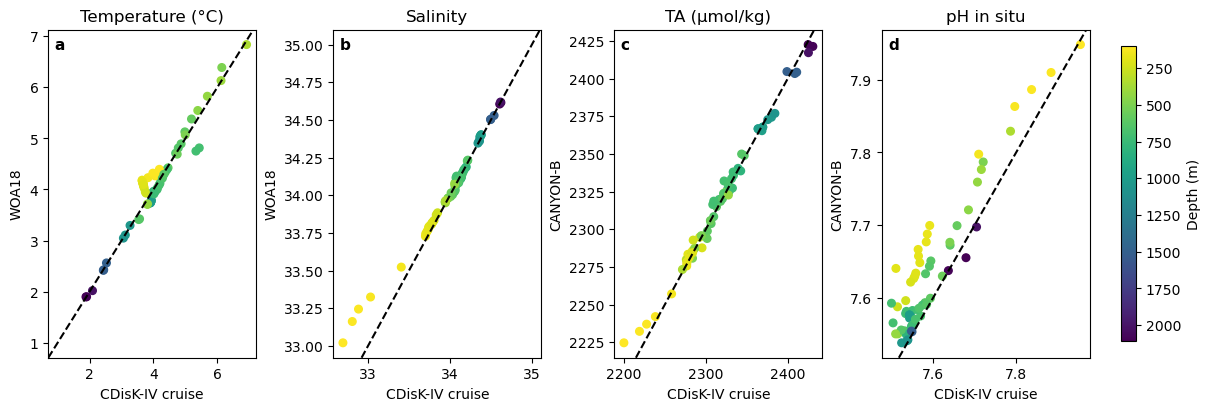

In [13]:
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(12,4), layout='compressed')

for a in axs.flatten():
    a.set_ylabel('WOA18')
    a.set_xlabel('CDisK-IV cruise')
    
axs[0].scatter(df_cdisk['Temp_CDisk4'], df_cdisk['Temp_woa'], c=df_cdisk['Depth'], cmap='viridis_r', s=30,
              #edgecolor='black', linewidth=0.3
              )
axs[0].axline((1,1), slope=1, color='black', linestyle='--')
axs[0].set_title('Temperature (°C)')
axs[0].set_ylabel('WOA18')

axs[1].scatter(df_cdisk['Salinity_CDisk4'], df_cdisk['Sal_woa'], c=df_cdisk['Depth'], cmap='viridis_r', s=30,
              #edgecolor='black', linewidth=0.3
              )
axs[1].axline((35,35), slope=1, color='black', linestyle='--')
axs[1].set_title('Salinity')
axs[1].set_ylabel('WOA18')

axs[2].scatter(df_cdisk['TA_CDisk4'], df_cdisk['TA_cb'], c=df_cdisk['Depth'], cmap='viridis_r', s=30,
              #edgecolor='black', linewidth=0.3
              )
axs[2].axline((2400,2400), slope=1, color='black', linestyle='--')
axs[2].set_title('TA (µmol/kg)')
axs[2].set_ylabel('CANYON-B')

axs[3].scatter(df_cdisk['pH_insitu_CDisk4'], df_cdisk['pH_insitu_cb'], c=df_cdisk['Depth'], cmap='viridis_r', s=30,
              #edgecolor='black', linewidth=0.3
              )
axs[3].axline((7.7,7.7), slope=1, color='black', linestyle='--')
axs[3].set_title('pH in situ')
axs[3].set_ylabel('CANYON-B')

cbar = fig.colorbar(cb, ax=axs, label='Depth (m)', shrink=0.9, pad=0.03) 
cbar.ax.invert_yaxis()

for n,ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_lowercase[n], (0.03, 0.94), xycoords='axes fraction', weight='bold', fontsize=11)

#plt.suptitle('WOA vs cruise measurements', fontsize=14)

#plt.tight_layout()
plt.show()